# AlexNet implementation (with PyTorch)
Model from: https://pytorch.org/hub/pytorch_vision_alexnet/

Training loop from: https://kushaj.medium.com/training-alexnet-with-tips-and-checks-on-how-to-train-cnns-practical-cnns-in-pytorch-1-61daa679c74a

## Import required modules

In [248]:
import torch
from torch import nn, optim
from copy import deepcopy
from PIL import Image
from torchvision import transforms
from torchvision.io import read_image
import time
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
netsPath = '../nets/'

cpu


In [219]:
import random
random.seed(1234) # reproducibility seed

## Get model

### Get pretrained model from source

In [220]:
alexnet = torch.load(netsPath + "Alexnet_preTrained.pth")
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Data transformation

Set number of classifications labels

In [221]:
labels_list = ["DME", "NORMAL"]
num_labels = len(labels_list)

In [222]:
data_dir = '/volume/OCT/OCT2017/'
sets = ["train", "val", "test"]

In [223]:
import torchvision.transforms as transforms

size = 224 # given by alexnet

transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [277]:
# Load image form given path and convert into RGB mode
def imageToTensor(path, transform=None):
    im = read_image(path)
    if im.mode != "RGB":
        im = im.convert("RGB")
    if transform:
        im = transform(im)
    else:
        im = transforms.ToTensor()(im)
    return im

# Load images from path for given labels and apply given transform and split into batches
def loadDataset(data_dir, set_name, labels, transform=None, batch_size=None):
    images_data = tuple(); labels_data = tuple();
    # Load data for each given label
    for lab in range(len(labels)):
        path = f"{data_dir}{set_name}/{labels[lab]}/"
        imgs = [imageToTensor(loadImage(f"{path}/{ima}")) for ima in os.listdir(path)]
        labs = (lab) * len(imgs)
        images_data.extend(imgs)
        labels_data.extend(labs)
    # Split into batches if desired
    if batch_size:
        ims_size = len(images_data);
        data_batches = tuple();
        # Split into batches and add batch_size images into each
        for batch in range(0, ims_size, batch_size):
            data_batches.append((images_data[batch:batch + batch_size], torch.tensor(labels_data[batch:batch + batch_size]))) # each batch have imgs and labels
        return data_batches
    return images_data, torch.tensor(labels_data)

In [276]:
#os.listdir(f"{data_dir}/val/NORMAL")
tens = imageToTensor(f"{data_dir}/val/NORMAL/NORMAL-4872585-1.jpeg")

<ipython-input-276-35eb7a3c6fb3>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nTen = torch.tensor(tens)


torch.Size([6, 496, 512])

#### Create train and test sets

In [266]:
batch_size = 32 # prefered by alexnet

#trnX, trnY = loadDataset(data_dir, "train", labels_list, transform)
valBatch = loadDataset(data_dir, "val", labels_list, transform, batch_size=4)
#tstX, tstY = loadDataset(data_dir, "test", labels_list, transform, batch_size)

TypeError: object of type 'generator' has no len()

Sets shape

In [226]:
#print(f"Train set size: {len(trnY)}")
print(f"Test set size: {len(tstY)}")
print(f"Val set size: {len(valY)}")

Test set size: 16
Val set size: 16


In [231]:
imoAlexnet.eval()
inps = valBatch[0][0]
inps = torch.unsqueeze(inps, 0)
inps
#inps = torch.cat(inps)
#imoAlexnet()

TypeError: unsqueeze(): argument 'input' (position 1) must be Tensor, not list

Check labels and images

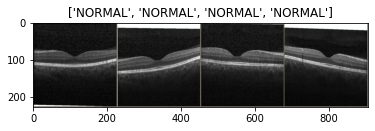

In [187]:
import numpy as np
import matplotlib.pyplot as plt

# Our images are normalized so denormalize then and convert them to numpy
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std*img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    


images, labels = valX[-4:], valY[-4:]
grid_img = make_grid(images, nrow=4)
imshow(grid_img, title = [labels_list[x] for x in labels[-4:]])

## IMO model

### Modify architecture

In [227]:
def newAlexNet(num_labels):
    newAlexnet = deepcopy(alexnet)
    lastLayer = newAlexnet.classifier[-1] # get usual last layer
    newAlexnet.classifier[-1] = nn.Linear(lastLayer.in_features, num_labels) # modify last layer number of outputs (labels to be classified)
    return newAlexnet

imoAlexnet = newAlexNet(num_labels)

### Set hiperparameters

In [199]:
learning_rate = 0.001
momentum = 0.9
epochs = 3

### Loss function, optimizer and scheduler

In [200]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(limoAlexnet.parameters(), lr=learning_rate, momentum=momentum)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

### Train loop

In [212]:
def train(model, data, criterion, optimizer, scheduler = None, num_epochs=100, seed=None):
    n_batches = len(data["train"])
    if epochs > n_batches:
        raise ValueError("Epochs greater than number of batches.")
    
    data_len = sum([len(batch) for batch in data["train"]])
    
    # Get training time
    since = time.time()
    if seed:
        random.seed(seed)
    
    train_batch_loss = []
    train_epoch_loss = []
    val_epoch_loss = []
    batches = [i for i in range(n_batches)]
    
    model.to(device)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*15)
        
        valBatch = batches.pop(random.randint(a=0, b=len(batches))) # select a random batch as validation
        
        #### Train model this epoch ####
        model.train()
        running_loss = 0; running_corrects = 0; train_cases = 0;

        for idx, batch in enumerate(data["train"]):
            if idx == valBatch:
                continue
            inputs = batch[0]
            labels = batch[1]
            inputs = torch.tensor(inputs).to(device)
            labels = labels.to(device)

            # zero accumulated gradients
            optimizer.zero_grad()

            # During train phase we want to remember history for grads
            # and during val we do not want history of grads
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                if idx%200 == 0 or idx == num_batches - 1:
                    train_batch_loss.append(loss.item())
                    print('Epoch {}: {}/{} steps in progress'.format(epoch+1, idx+1, n_batches-1))

                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            train_cases += len(preds)
        
        epoch_loss = running_loss / train_cases
        epoch_acc = running_corrects.double() / train_cases
        
        train_epoch_loss.append((epoch_loss, epoch_acc))
        
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
        #### Validate model this epoch ####
        model.eval()
        
        running_loss = 0; running_corrects = 0; val_cases = 0;
        
        inputs, labels = data["train"][valBatch]
        inputs = torch.tensor(inputs).to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        
        val_cases = len(preds)
        
        epoch_loss = loss.item() * inputs.size(0) / val_cases
        epoch_acc = torch.sum(preds == labels.data).double() / val_cases

        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
            
        val_epoch_loss.append((epoch_loss, epoch_acc))
        if scheduler:
            scheduler.step(loss.item())
                
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return model

### Train model with train set

In [213]:
trainedLimoModel = train(imoAlexnet, {"train": valBatch}, loss_fn, optimizer, scheduler, epochs, seed=123)

Epoch 1/3
---------------


ValueError: only one element tensors can be converted to Python scalars

Evaluate model over test set

In [ ]:
trainedLimoModel.eval() # set model to be evaluated (ignore grads)
confMatrix = np.zeros((num_labels, num_labels), dtype=int)
trainedLimoModel.eval()
for batchNum, (inputs, labels) in enumerate(data_loader["test"]):
    outputs = trainedLimoModel(inputs)
    _, preds = torch.max(outputs, 1)
    for i, pred in enumerate(preds):
        confMatrix[pred, labels[i]] += 1
        
testAcc = confMatrix.trace() / confMatrix.sum()
print(f'Test set accuracy: {testAcc}')

Confusion matrix

In [ ]:
import seaborn as sns
x_axis_labels = labels_list # labels for x-axis
y_axis_labels = labels_list # labels for y-axis
ax = sns.heatmap(confMatrix, cmap="Blues", annot=True, fmt="d", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix");

In [ ]:
accLabel = {labels_list[lab]: confMatrix[lab, lab] / sum(confMatrix[:, lab]) for lab in range(num_labels)}
print(f"Acc by label: {accLabel}")

Save model into files (saved models listed in file)

In [ ]:
netVer = len(os.listdir(path))
netType = "alexnet"
netID = "_".join([netType, str(netVer)])
torch.save(trainedLimoModel, netsPath + netID + ".pth")

Load saved model

In [ ]:
model = torch.load(path + netID + ".pth")
model.eval()